# NPZD slab model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc

In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra
from phydra.processes.main import Grid0D,Boundary0D

from phydra.processes.fluxes import Flux, LimitedGrowth, NutrientDependency, Mixing


from phydra.processes.components import make_Component, Component, AllComponents, Time
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve

from phydra.utility.xsimlabwrappers import phydra_setup, createSingleComp, createMultiComp, specifyComps4Flux

In [3]:
from phydra.processes.forcing import Forcing, NutrientForcing

In [4]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.65.g1e8d831.dirty


In [5]:
Nutrient = make_Component('Nutrient','N')

xs.process_info(Nutrient)

<Nutrient  (xsimlab process)>
Variables:
    m               [in] <--- GekkoContext.m
    gk_context      [in] <--- GekkoContext.context
    gk_SVs          [in] <--- GekkoContext.SVs
    gk_SVshapes     [in] <--- GekkoContext.SVshapes
    gk_Fluxes       [in] <--- GekkoContext.Fluxes
    gridshape       [in] <--- GekkoContext.shape
    index          [out] N 
    output         [out] ('N', 'time') 
    init            [in]
    label           [in]
    dim             [in]
Simulation stages:
    initialize
    run_step
    finalize_step


In [6]:
model = xs.Model({
    'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 
    
    'context':GekkoContext,
                  
    'N':make_Component('Nutrient','N'), 'P':make_Component('Phytoplankton','P'),
    'Z':make_Component('Zooplankton','Z'), 'D':make_Component('Detritus','D'),
    'AllComps':AllComponents, 
    
    'P_Growth':LimitedGrowth, 

    'N_Mixing':Mixing, 
    'N0':NutrientForcing, 
    
    'solver':GekkoSolve
})

model

<xsimlab.Model (13 processes, 22 inputs)>
context
time
    days           [in] ('time',) time in days
grid
    length         [in]
    shape          [in]
ibcs
    ibc            [in] Initial Boundary Conditions
N
    init           [in]
    dim            [in]
    label          [in]
P
    dim            [in]
    label          [in]
    init           [in]
Z
    init           [in]
    dim            [in]
    label          [in]
D
    init           [in]
    dim            [in]
    label          [in]
AllComps
P_Growth
    C_label        [in] label of component that grows
    halfsat        [in] half-saturation constant of nutrient uptake...
    mu             [in] Maximum growth rate of component
    R_label        [in] label of ressource component that is consumed
N0
N_Mixing
    C_label        [in] label of component that grows
    mixingrate     [in]
solver

In [7]:
model.index_vars 

[('time', 'time'),
 ('N', 'index'),
 ('P', 'index'),
 ('Z', 'index'),
 ('D', 'index'),
 ('AllComps', 'components')]

In [12]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 6150)),
        
        'N':{'dim':1,'label':'N','init':1}, 
        'P':{'dim':1,'label':'P','init':1},
        'Z':{'dim':1,'label':'Z','init':1},
        'D':{'dim':1,'label':'D','init':1},
        
        'P_Growth':{'mu':0.1,
               'C_label':'P',
               'R_label':'N',
               'halfsat':0.5},
        
        'N_Mixing':{'mixingrate':0.1,
               'C_label':'N'}
    },
    output_vars={
        'AllComps__outputs':None
    }
                 )

In [13]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Gekko Context
Initializing Model Time
Initializing component  N
['N']
GKFLUXES SVFluxes dict stores: dict_items([])
Initializing component  P
['P']
GKFLUXES SVFluxes dict stores: dict_items([])
Initializing component  Z
['Z']
GKFLUXES SVFluxes dict stores: dict_items([])
Initializing component  D
['D']
GKFLUXES SVFluxes dict stores: dict_items([])
Initialize NutrientDependency
Growth Dependency_component: P []
DICTITEMS N i7 defaultdict(<class 'list'>, {'P': [], 'N': [0]})
DICTITEMS P i8 defaultdict(<class 'list'>, {'P': [0], 'N': [0]})
GK flux SVFluxes dict stores: dict_items([('P', [0]), ('N', [0])])
DICTITEMS N i9 defaultdict(<class 'list'>, {'P': [0], 'N': [0, 0]})
Assembling equation for component  N
FLUXES: v2 [0, 0]
[0, 0]
Assembling equation for component  P
FLUXES: v3 [0]
[0]
Assembling equation for component  Z
FLUXES: v4 []
[]
Assembling equation for component  D
FLUXES: v5 []
[]
SolveInit
Model context dict stores: dict_items([('shape', {'env': 1}), ('comp_dims

In [14]:
out_ds

<xarray.Dataset>
Dimensions:               (N: 1, clock: 2, components: 4, time: 6150)
Coordinates:
  * clock                 (clock) int64 0 1
  * components            (components) <U1 'N' 'P' 'Z' 'D'
  * time                  (time) int64 0 1 2 3 4 5 ... 6145 6146 6147 6148 6149
Dimensions without coordinates: N
Data variables:
    AllComps__outputs     (components, time) float64 1.0 1.025 1.043 ... 1.0 1.0
    D__dim                int64 1
    D__init               int64 1
    D__label              <U1 'D'
    N_Mixing__C_label     <U1 'N'
    N_Mixing__mixingrate  float64 0.1
    N__dim                int64 1
    N__init               int64 1
    N__label              <U1 'N'
    P_Growth__C_label     <U1 'P'
    P_Growth__R_label     <U1 'N'
    P_Growth__halfsat     float64 0.5
    P_Growth__mu          float64 0.1
    P__dim                int64 1
    P__init               int64 1
    P__label              <U1 'P'
    Z__dim                int64 1
    Z__init               int64 1
    Z__label              <U1 'Z'
    grid__length          int64 1
    grid__shape           int64 1
    ibcs__ibc             float64 nan
    index                 (N) <U1 'D'
    time__days            (time) int64 0 1 2 3 4 5 ... 6145 6146 6147 6148 6149

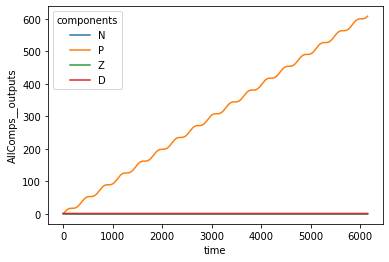

In [15]:
out_ds.AllComps__outputs.set_index(time='time',).plot.line(x='time')